# Curriculum Learning

In this notebook, we recreate the experiment performed by Bengio et. al in order to evaluate the efficacy of curriculum learning as a tool to improve the performance of neural networks.

### What is Curriculum Learning?

Curriculum Learning takes after the notion that humans and animals learn better when examples are presented in a meaningful order. This "meaningful order" is arbitrary, but ultimately should be decided by the engineer of the network who has a strong understanding of what an appropriate ordering of the data may look like.

We'll formalize the idea of a curriculum here. Let $z=(x,y)$ be a random variable that represents an example in supervised learning. Denote $P(z)$ the target training distribution from which the neural network learns a function of interest. Let $0 \leq W_\lambda(z) \leq 1$ be the weight applied to example $z$ at step $\lambda$ in the curriculum sequence so that $0 \leq \lambda \leq 1$ and $W_1(z) = 1$. The corresponding training distribution at step $\lambda$ is $Q_\lambda(z)$, which is proportional to $W_\lambda(z)P(z)$ for all $z$. We call a sequence of distributions $Q_\lambda$ a **curriculum** if the *entropy* of these distributions *increases* and $W_\lambda(z)$ is *monotonically increasing* in $\lambda$.

The mathematical formulation of a curriculum **checks out**: as the entropy of our training distributions increases, the classification task becomes much more difficult over time. In other words, a sequence of training distributions is a curriculum if there is some ordering of the training examples such that easier examples are presented before more difficult examples. In this way, curriculum learning only benefits a neural network's generalization error if the data used to train the network *is indeed* a curriculum. That is, the data used at the end of training must be **much** harder to learn that the examples from the beginning of training.

## Bengio et. al's Shape Recognition Experiment

The idea behind the shape experiment is simple: generate two datasets containing ``simple`` and ``complex`` geometric shapes. There were three classes of shapes used in the experiment: (0) ellipses, (1) rectangles, and (2) triangles.

``dataset_basic`` contains simple versions of the shapes listed above: circles, squares, and equilateral triangles.

``dataset_complex`` contains the shapes listed above. These shapes are more "complex" than the basic shapes:

1. An ellipse is defined by $\frac{(x-h)^2}{b^2} + \frac{(y-k)^2}{a^2} = 1$, and
   
2. A circle is defined by $(x-h)^2 + (y-k)^2 = r^2$. 

The parameters $a,b$ in the ellipse equation illustrate a more complex shape (note that a circle is defined by the ellipse equation with $a=b=1$) than a circle.

The same ideas hold for squares and rectangles since squares are a special kind of rectangle. Likewise, we theorize equilateral triangles are an "easier" shape to recognize compared to isosceles or scalene triangles.

``dataset_combined`` contains a 50-50 split of shapes from ``dataset_basic`` and ``dataset_complex``. This is the final metric used for testing the models after training.

In [59]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import torch
torch.manual_seed(0)
from datagen import generate_shape_dataset

# example distribution: 10000 train, 5000 validation, 5000 test
dataset_size = 20000
image_size = 32

dataset_basic, labels_basic = generate_shape_dataset(
    num_examples=dataset_size, image_size=image_size, complex=False)
dataset_complex, labels_complex = generate_shape_dataset(
    num_examples=dataset_size, image_size=image_size, complex=True)

# we only want total number of examples to be 20000; ensure distribution of basic and complex examples is 50-50
dataset_combined = torch.cat((dataset_basic[:dataset_size//2], dataset_complex[:dataset_size//2]), dim=0)
labels_combined = torch.cat((labels_basic[:dataset_size//2], labels_complex[:dataset_size//2]), dim=0)

/Users/jonathoncarl/s24/cs381/curriculum-learning/datagen.py:211: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return tensor(dataset, dtype=torch.float32), tensor(labels, dtype=torch.long)


In [2]:
torch.save(dataset_basic, 'data/dataset_basic.pt')
torch.save(labels_basic, 'data/labels_basic.pt')
torch.save(dataset_complex, 'data/dataset_complex.pt')
torch.save(labels_complex, 'data/labels_complex.pt')
torch.save(dataset_combined, 'data/dataset_combined.pt')
torch.save(labels_combined, 'data/labels_combined.pt')

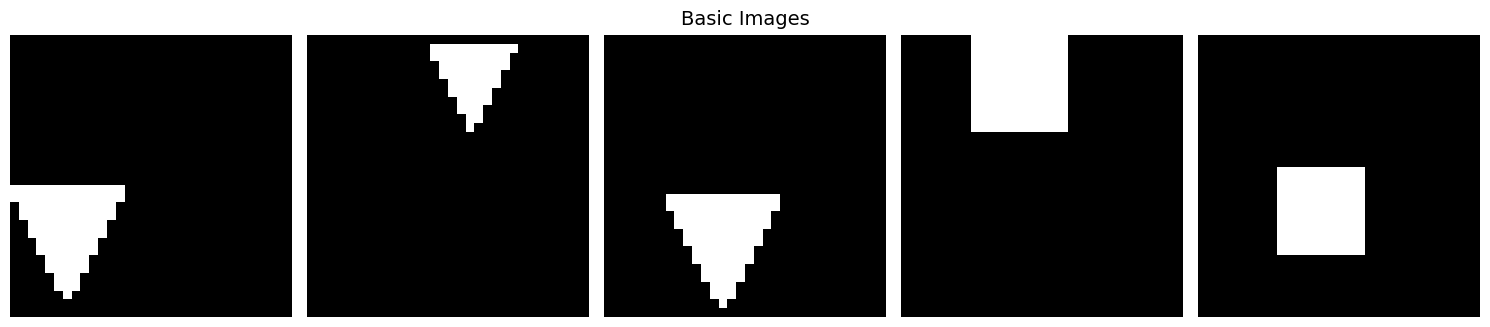

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# visualize a few examples
fig, axes = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):

    axes[i].imshow(dataset_basic[i], cmap='gray')
    axes[i].axis('off')

plt.suptitle('Basic Images', y=0.75, fontsize=14)

plt.tight_layout()
plt.show()

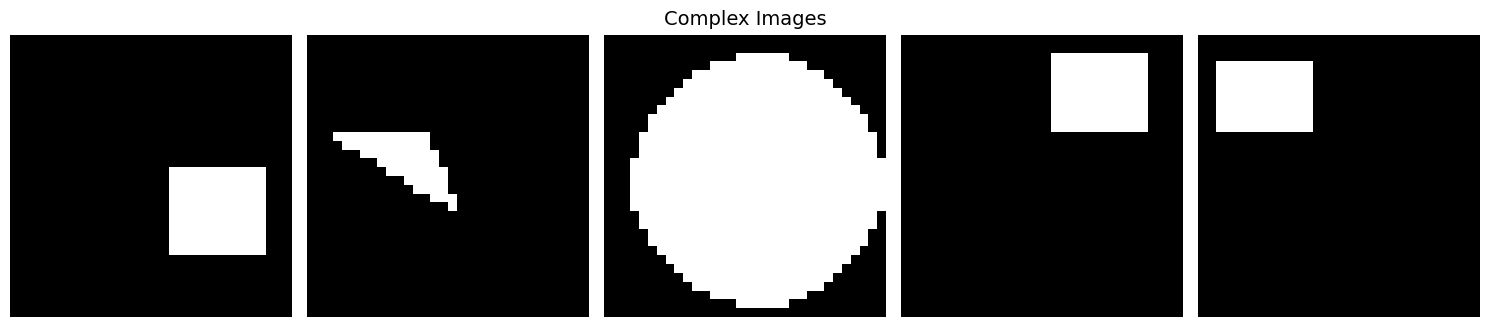

In [4]:
fig, axes = plt.subplots(1, 5, figsize=(15, 6))

for i in range(5):

    axes[i].imshow(dataset_complex[i], cmap='gray')
    axes[i].axis('off')

plt.suptitle('Complex Images', y=0.75, fontsize=14)
plt.tight_layout()
plt.show()

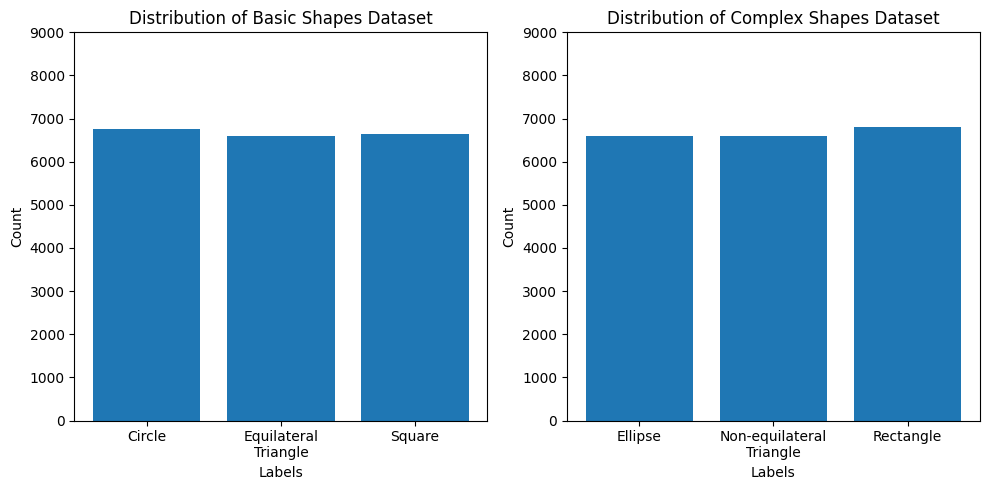

In [5]:
from collections import Counter

dataset_basic_counts = Counter(labels_basic.tolist())
dataset_complex_counts = Counter(labels_complex.tolist())
# Plotting the histograms
plt.figure(figsize=(10, 5))

# Plot histogram for Basic Shapes
plt.subplot(1, 2, 1)
plt.bar(dataset_basic_counts.keys(), dataset_basic_counts.values())
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(list(range(3)), ['Circle', 'Equilateral\nTriangle',
           'Square'])
plt.yticks(list(range(0, 10000, 1000)))
plt.title('Distribution of Basic Shapes Dataset')

# Plot histogram for Complex Shapes
plt.subplot(1, 2, 2)
plt.bar(dataset_complex_counts.keys(), dataset_complex_counts.values())
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(list(range(3)), ['Ellipse',
           'Non-equilateral\nTriangle', 'Rectangle'])
plt.yticks(list(range(0, 10000, 1000)))
plt.title('Distribution of Complex Shapes Dataset')

plt.tight_layout()
plt.show()

In [6]:
from datagen import prepare_data

num_classes= 3
batch_size = 100

train_loader_basic, val_loader_basic, test_loader_basic = prepare_data(
    dataset=dataset_basic, labels=labels_basic, batch_size=batch_size,
    num_classes=num_classes, shuffle=False, data_type=0)

train_loader_complex, val_loader_complex, test_loader_complex = prepare_data(
    dataset=dataset_complex, labels=labels_complex, batch_size=batch_size,
    num_classes=num_classes, shuffle=False, data_type=1)

train_loader_combined, val_loader_combined, test_loader_combined = prepare_data(
    dataset=dataset_combined, labels=labels_combined, batch_size=batch_size,
    num_classes=num_classes, shuffle=True, data_type=2)

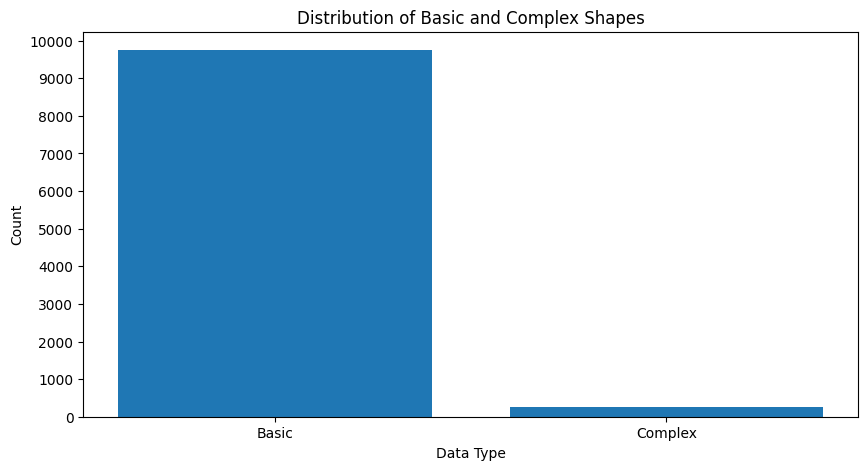

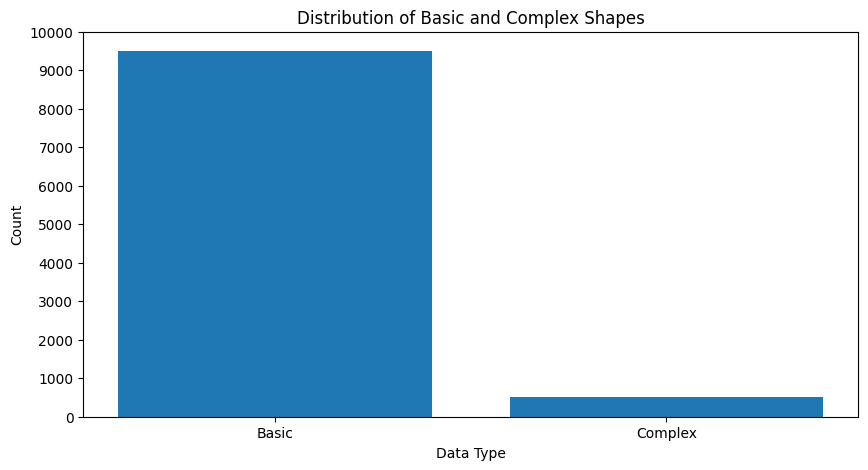

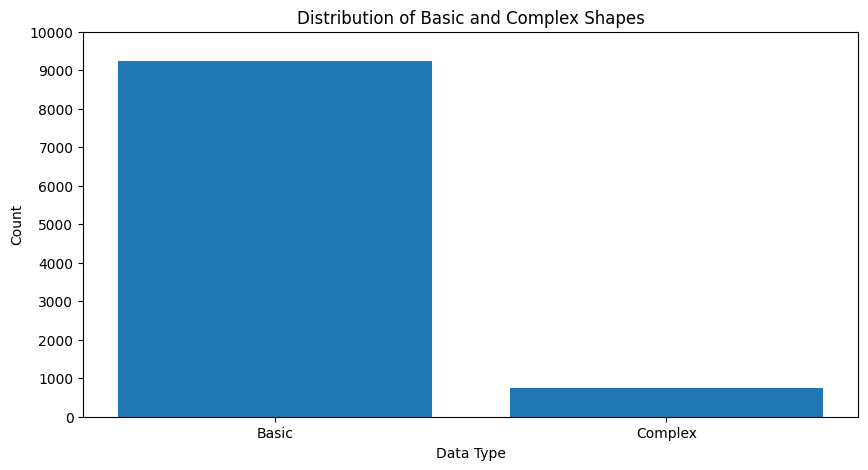

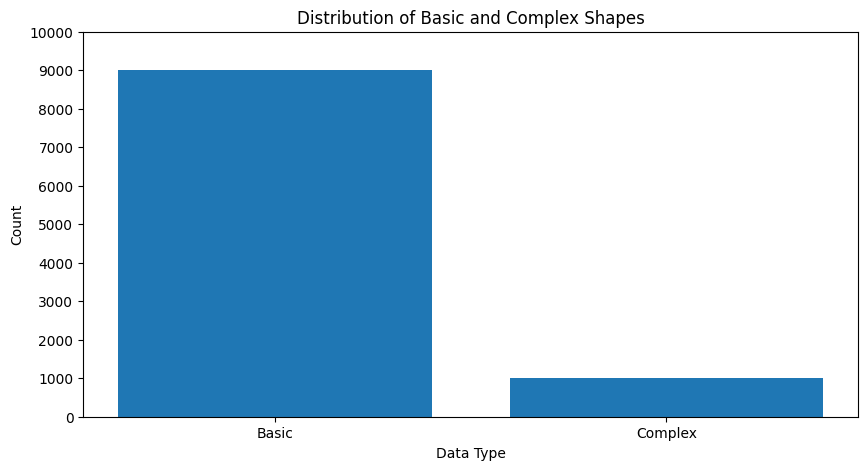

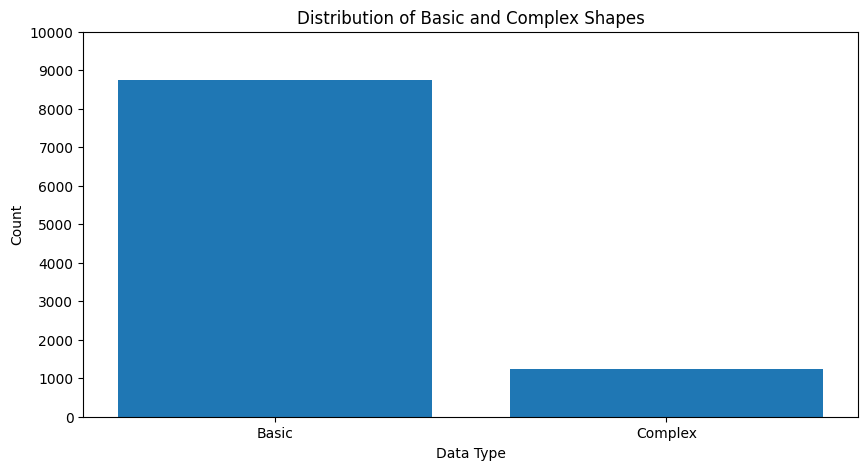

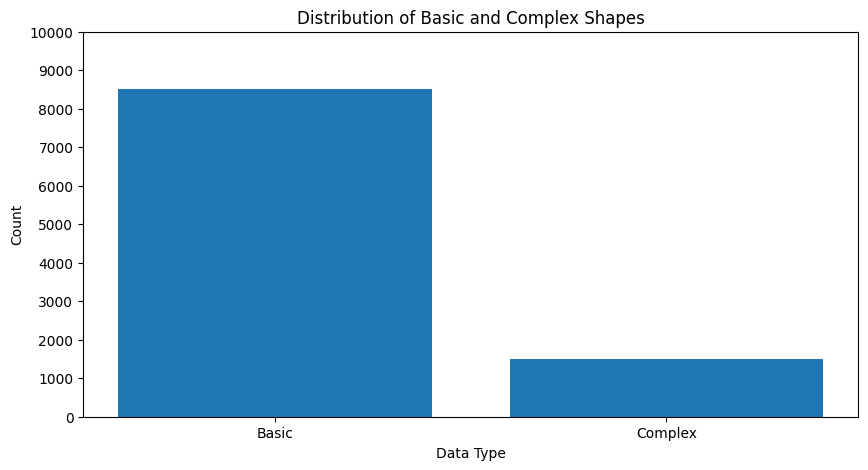

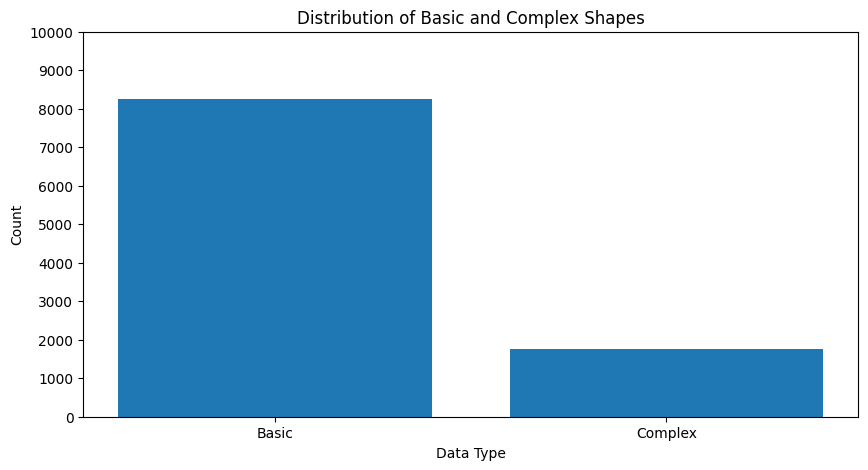

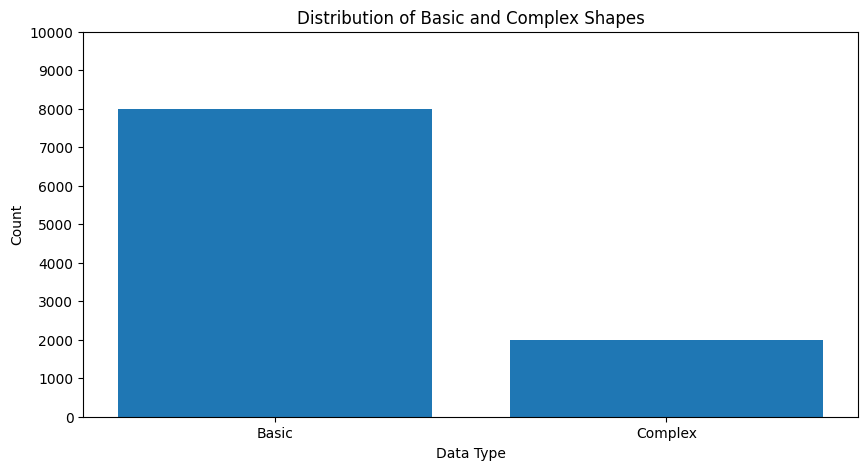

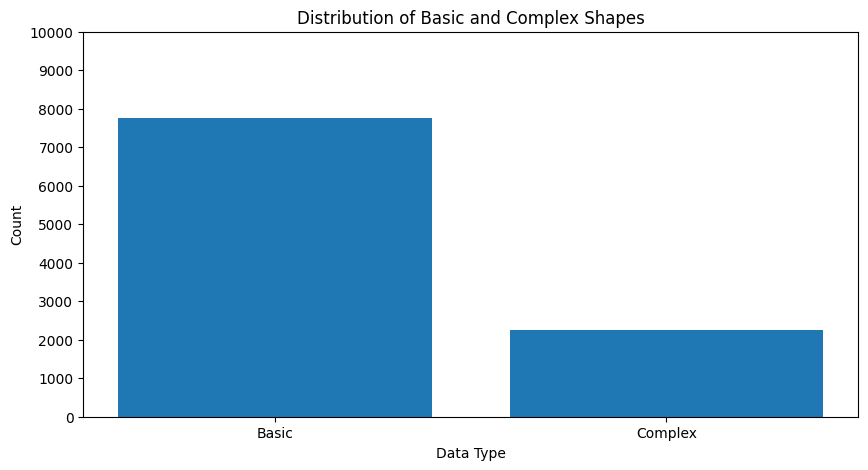

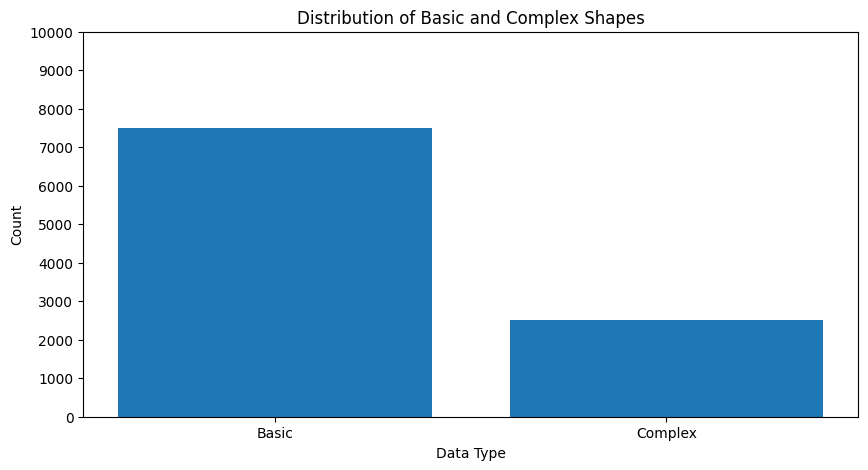

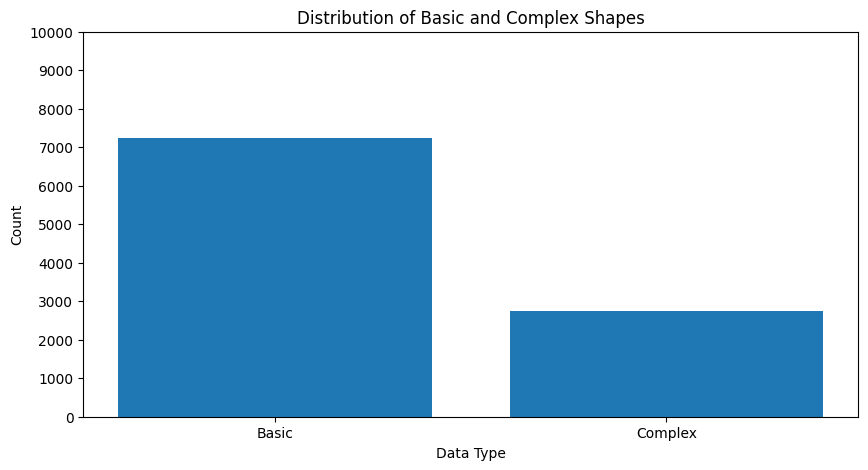

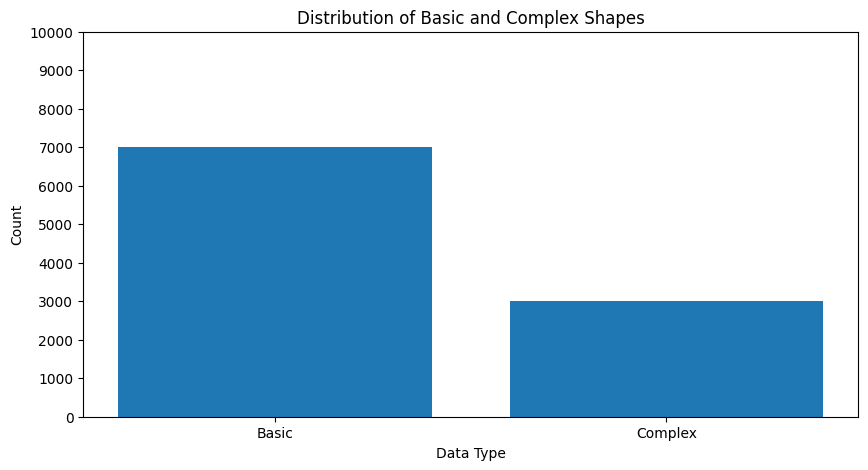

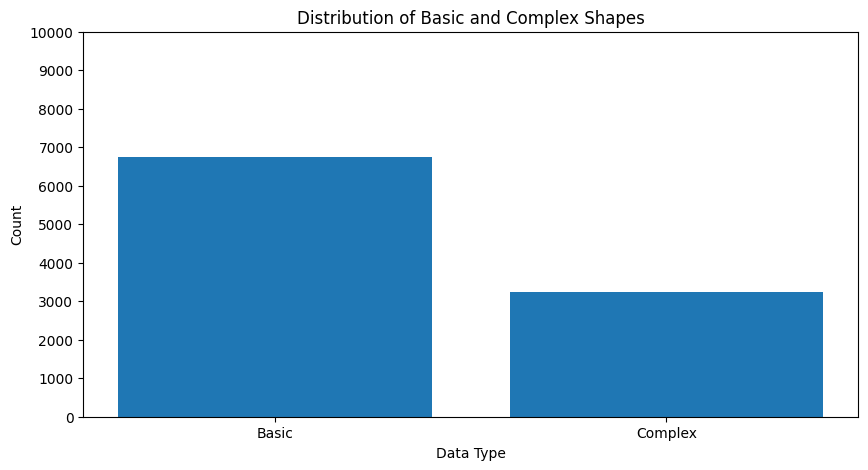

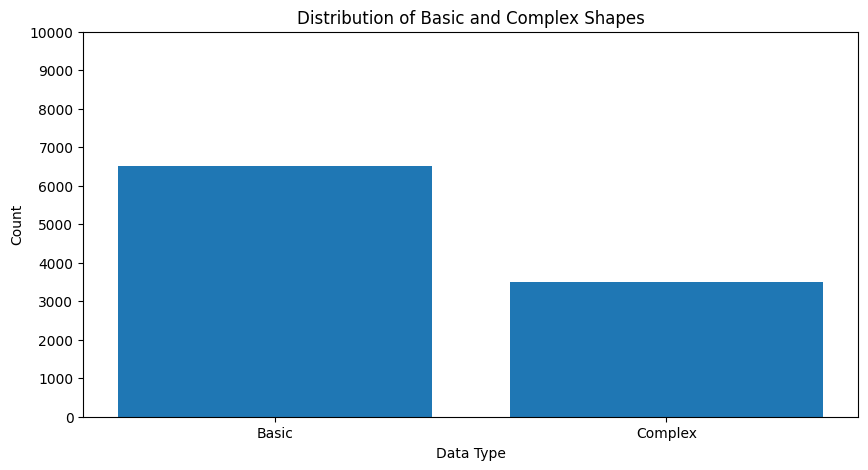

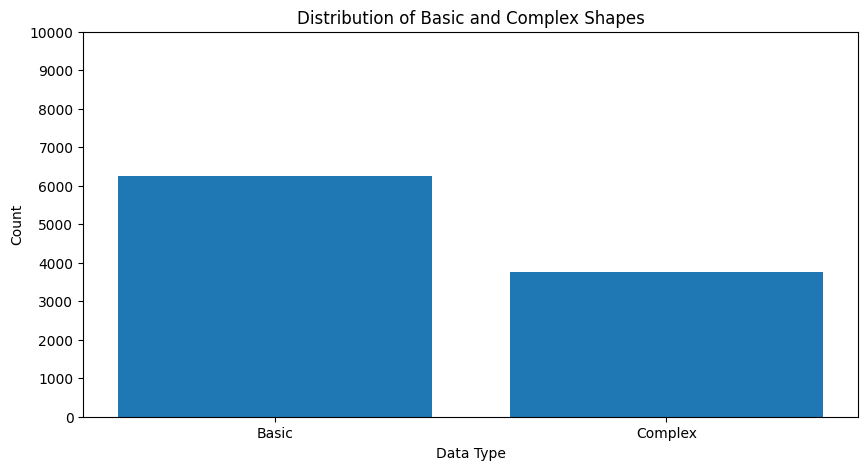

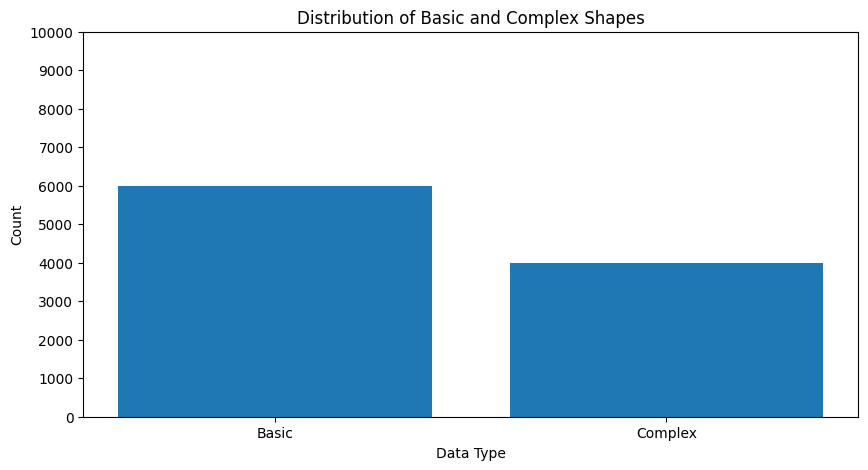

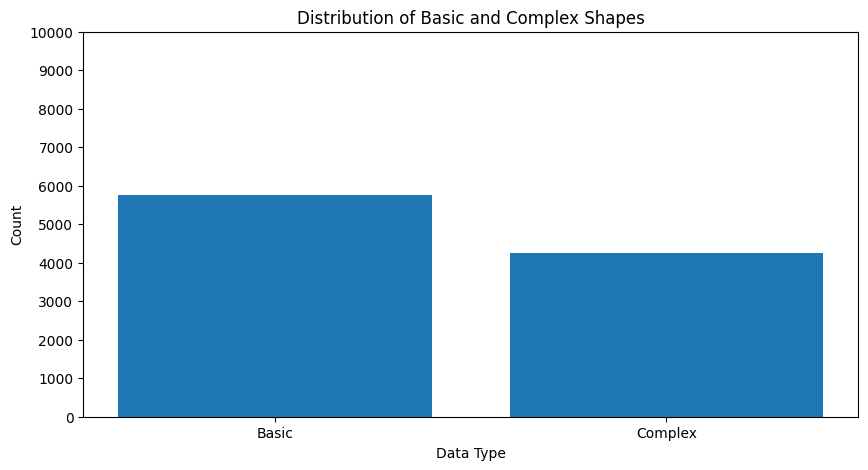

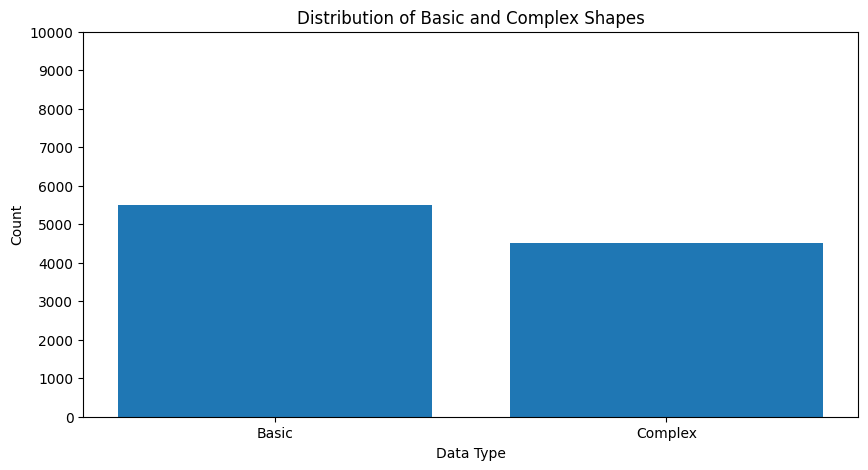

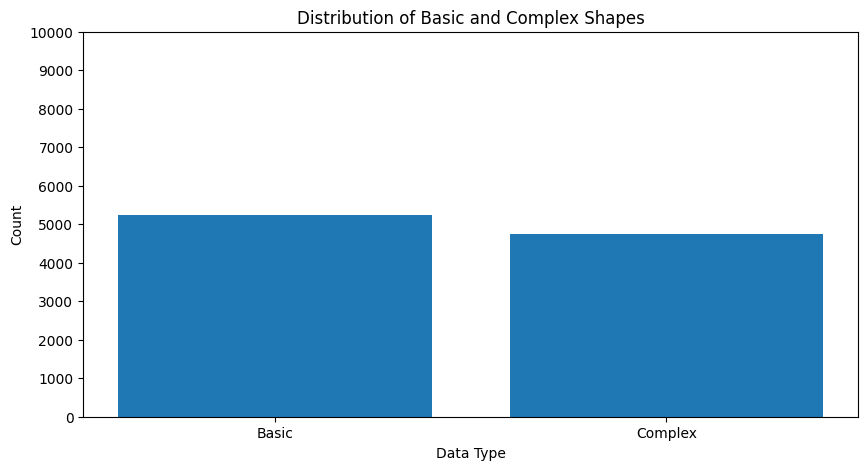

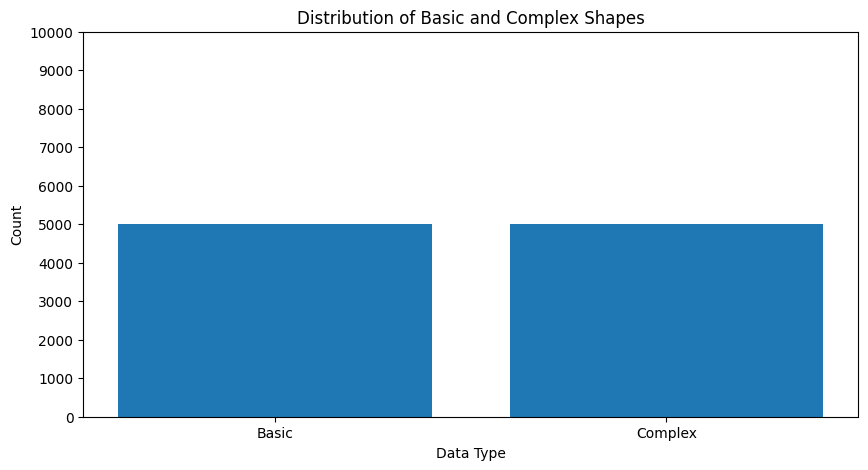

In [7]:
from datagen import generate_proportional_data

def gradual_complexity_increase(curr_loader, combined_loader, p):
    proportional_dataloader = generate_proportional_data(curr_loader, combined_loader, curr_p=p)
    shape_dataset = proportional_dataloader.dataset

    plt.figure(figsize=(10, 5))

    # Plot histogram for Basic Shapes
    plt.bar(['basic', 'complex'], [shape_dataset.basic_counts, shape_dataset.complex_counts])
    plt.xlabel('Data Type')
    plt.ylabel('Count')
    plt.xticks(list(range(2)), ['Basic', 'Complex'])
    plt.yticks(list(range(0, 11000, 1000)))
    plt.title('Distribution of Basic and Complex Shapes')

    return proportional_dataloader

curr_loader = train_loader_basic
new_loader = None
for i in range(1, 21):
    new_loader = gradual_complexity_increase(curr_loader, train_loader_combined, p=0.05*i)
    curr_loader = new_loader

In [8]:
from model import grid_search
import json, os

input_size = image_size * image_size

# Hyperparameters to tune
param_grid = {
    'hidden_sizes': [32, 64, 128, 256],
    'learning_rates' : [0.001, 0.01, 0.1]
}


file_path = 'models/optimal_hyperparameters.json'
best_params = None
if os.path.isfile(file_path):
    with open(file_path, 'r') as f:
        best_params = json.load(f)
else:
    # only run a grid search if we haven't yet determined optimal hyperparameters
    best_params, best_acc = grid_search(param_grid, train_loader_complex, input_size=input_size, val_loader=val_loader_complex)
    with open(file_path, 'w') as f:
        json.dump(best_params, f)
    print("Optimal hyperparameters saved to 'optimal_hyperparameters.json'.")

print("Optimal hyperparameters selected by maximizing complex validation accuracy.")
print(best_params)

Optimal hyperparameters selected by maximizing complex validation accuracy.
{'hidden_size': 128, 'learning_rate': 0.001}


In [9]:
from torch import nn, optim

hidden_size = best_params['hidden_size']
learning_rate = best_params['learning_rate']
ce_loss = nn.CrossEntropyLoss()
num_epochs = 256
input_size = image_size * image_size
save_model = True

Training basic model on basic data...


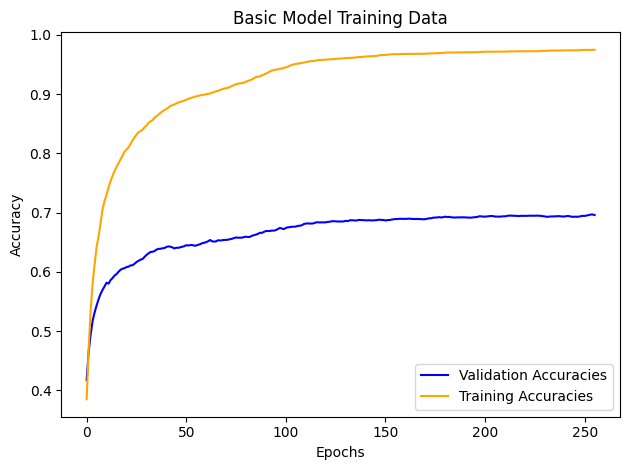

basic validation accuracy after training: 0.6958
Basic data training complete for basic model!


In [11]:
from model import FeedForward, train_model

model_basic = FeedForward(input_size=input_size,
                          hidden_size=hidden_size, output_size=num_classes)

optimizer_basic = optim.SGD(model_basic.parameters(), lr=learning_rate)

print("Training basic model on basic data...")
model_basic, _ = train_model(model=model_basic, loader=train_loader_basic,
                            loss_fn=ce_loss, optimizer=optimizer_basic,
                            num_epochs=num_epochs, verbose=True,
                            val_loader=val_loader_combined, model_type='basic',
                            plot_title='Basic Model Training Data')

print("Basic data training complete for basic model!")

if save_model:
    torch.save(model_basic.state_dict(), 'models/model_basic.pth')

Training curriculum models...
Training curriculum models with Combined Switch Loader...
Training curriculum model at switch epoch=0
Curriculum training on basic data complete. Now training curriculum model on complex data...


Gradual switching phase complete. Now training completely on switch loader data...


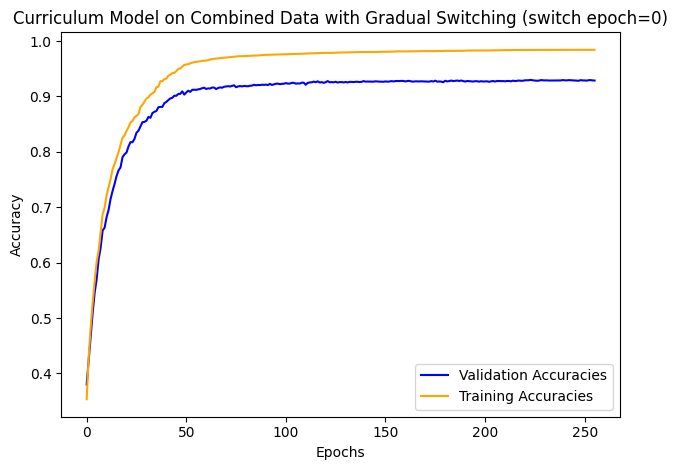

Validation accuracy of model at switch epoch 0: 0.9288
Training curriculum model at switch epoch=2


Curriculum training on basic data complete. Now training curriculum model on complex data...


Gradual switching phase complete. Now training completely on switch loader data...


Model training has reached early stopping at epoch 209.


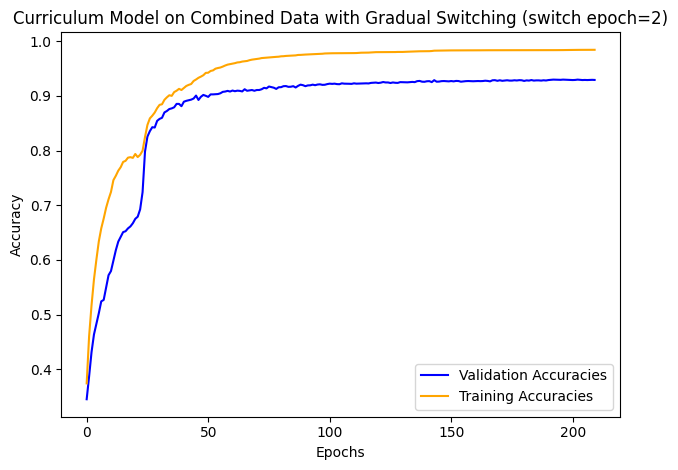

Validation accuracy of model at switch epoch 2: 0.9292
Training curriculum model at switch epoch=4


Curriculum training on basic data complete. Now training curriculum model on complex data...


Gradual switching phase complete. Now training completely on switch loader data...


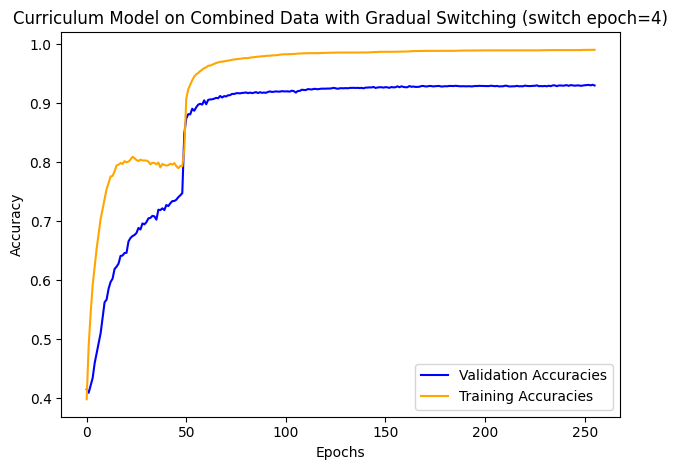

Validation accuracy of model at switch epoch 4: 0.93
Training curriculum model at switch epoch=8


Curriculum training on basic data complete. Now training curriculum model on complex data...


Gradual switching phase complete. Now training completely on switch loader data...


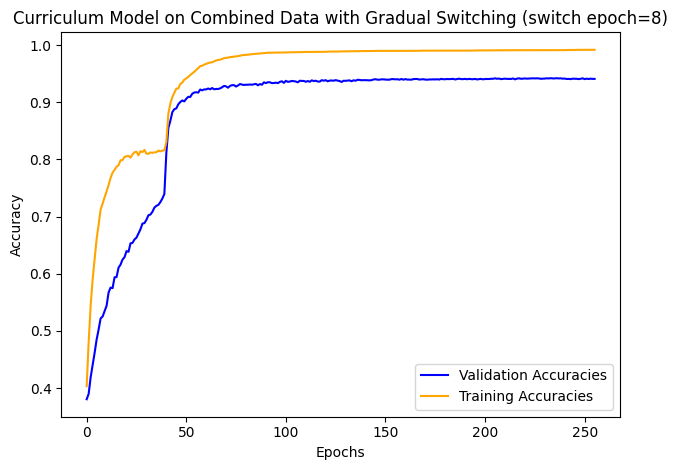

Validation accuracy of model at switch epoch 8: 0.941
Training curriculum model at switch epoch=16


Curriculum training on basic data complete. Now training curriculum model on complex data...


Gradual switching phase complete. Now training completely on switch loader data...


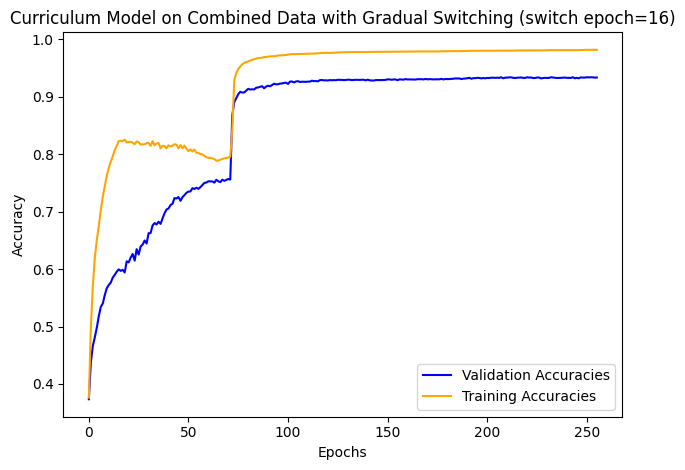

Validation accuracy of model at switch epoch 16: 0.9338
Training curriculum model at switch epoch=32


Curriculum training on basic data complete. Now training curriculum model on complex data...


Gradual switching phase complete. Now training completely on switch loader data...


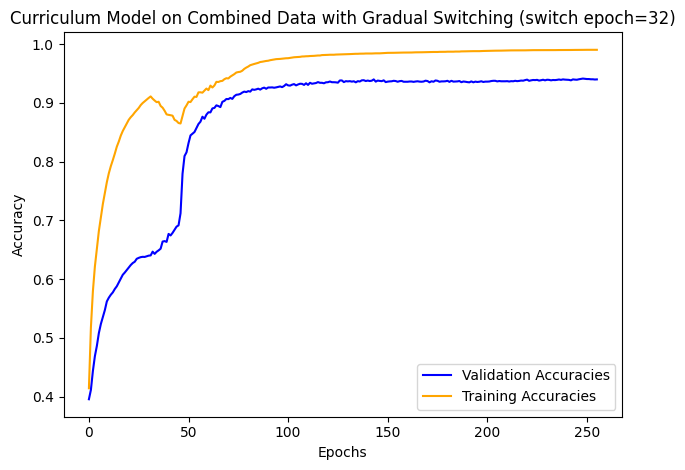

Validation accuracy of model at switch epoch 32: 0.9402
Training curriculum model at switch epoch=64


Curriculum training on basic data complete. Now training curriculum model on complex data...


Gradual switching phase complete. Now training completely on switch loader data...


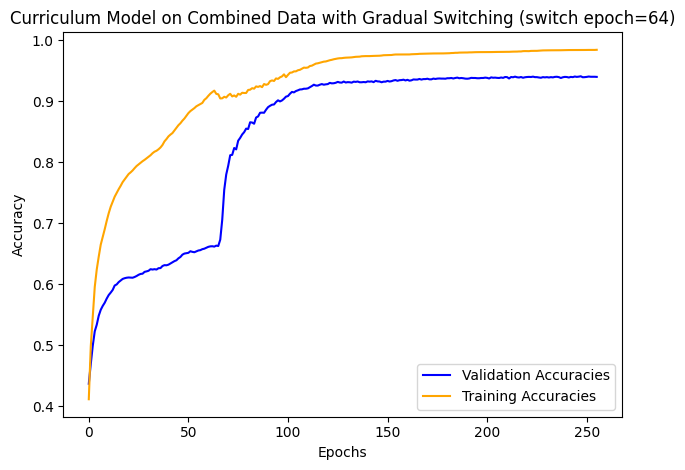

Validation accuracy of model at switch epoch 64: 0.9398
Training curriculum model at switch epoch=128


Curriculum training on basic data complete. Now training curriculum model on complex data...


Gradual switching phase complete. Now training completely on switch loader data...


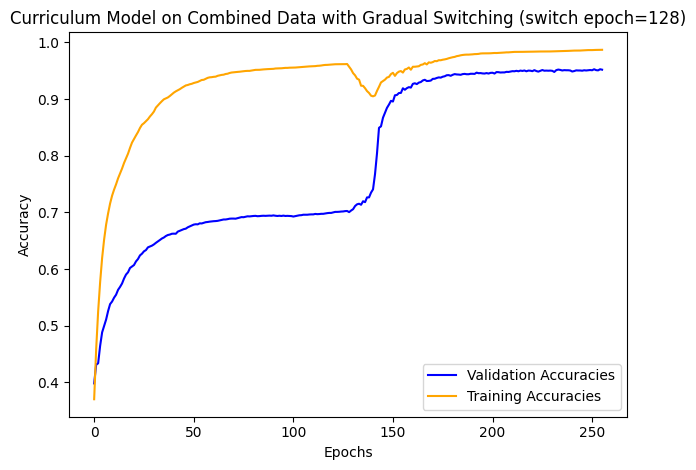

Validation accuracy of model at switch epoch 128: 0.952


In [13]:
from experiment import curriculum_experiment

# train the curriculum model on the basic dataset first, then the complex one
print("Training curriculum models...")

# gradually switch from basic to complex data after switch epoch is reached
gs_combined_curriculum_accs = curriculum_experiment(input_size=input_size, hidden_size=hidden_size, learning_rate=learning_rate, val_loader=val_loader_combined,
                                                    loader_basic=train_loader_basic, loader_combined=train_loader_combined, 
                                                    switch_loader_name='Combined', save_model=True, gradual_switch=True, 
                                                    plot_title='Curriculum Model on Combined Data with Gradual Switching')

Training curriculum models with Combined Switch Loader...
Training curriculum model at switch epoch=0
Curriculum training on basic data complete. Now training curriculum model on complex data...


Gradual switching phase complete. Now training completely on switch loader data...


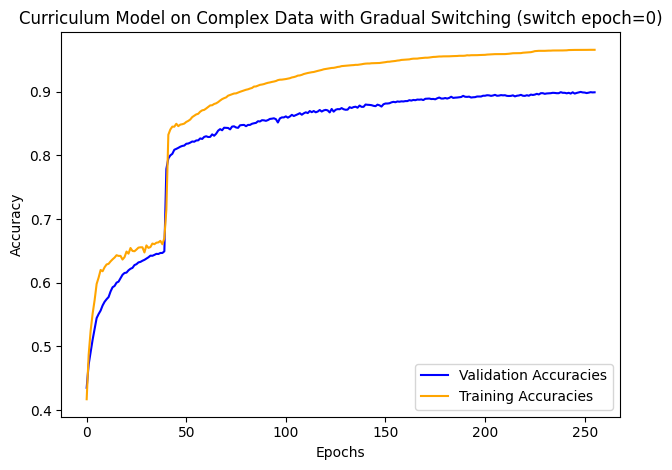

Validation accuracy of model at switch epoch 0: 0.899
Training curriculum model at switch epoch=2


Curriculum training on basic data complete. Now training curriculum model on complex data...


Gradual switching phase complete. Now training completely on switch loader data...


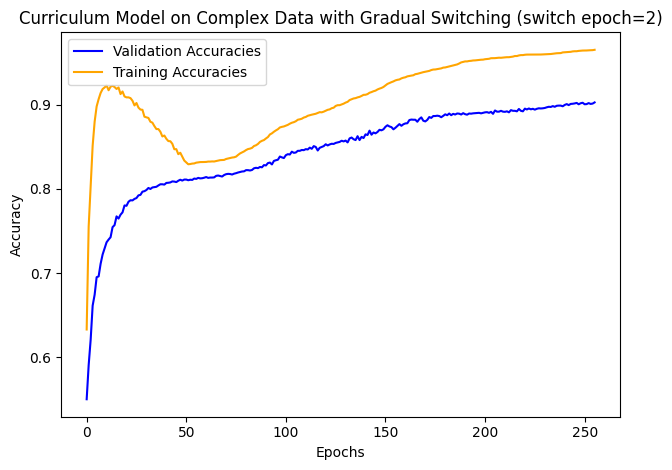

Validation accuracy of model at switch epoch 2: 0.903
Training curriculum model at switch epoch=4


Curriculum training on basic data complete. Now training curriculum model on complex data...


Gradual switching phase complete. Now training completely on switch loader data...


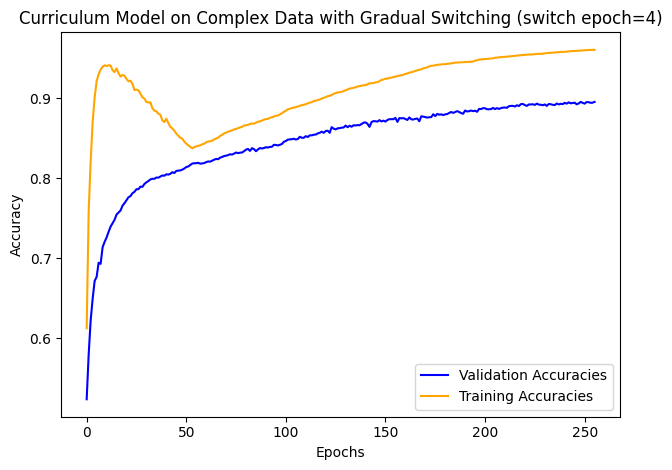

Validation accuracy of model at switch epoch 4: 0.8952
Training curriculum model at switch epoch=8


Curriculum training on basic data complete. Now training curriculum model on complex data...


Gradual switching phase complete. Now training completely on switch loader data...


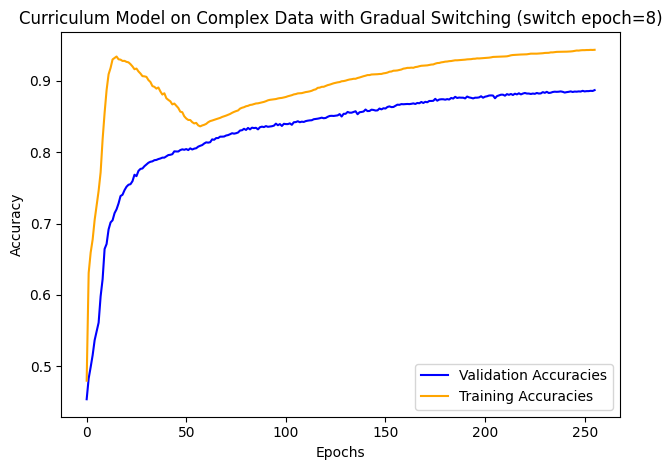

Validation accuracy of model at switch epoch 8: 0.887
Training curriculum model at switch epoch=16


Curriculum training on basic data complete. Now training curriculum model on complex data...


Gradual switching phase complete. Now training completely on switch loader data...


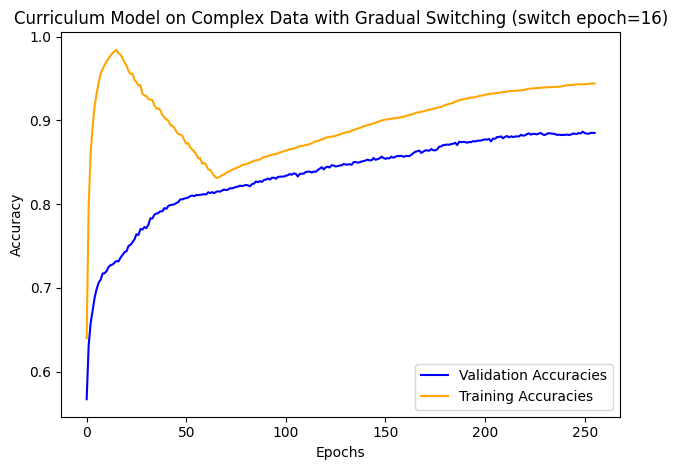

Validation accuracy of model at switch epoch 16: 0.885
Training curriculum model at switch epoch=32


Curriculum training on basic data complete. Now training curriculum model on complex data...


Gradual switching phase complete. Now training completely on switch loader data...


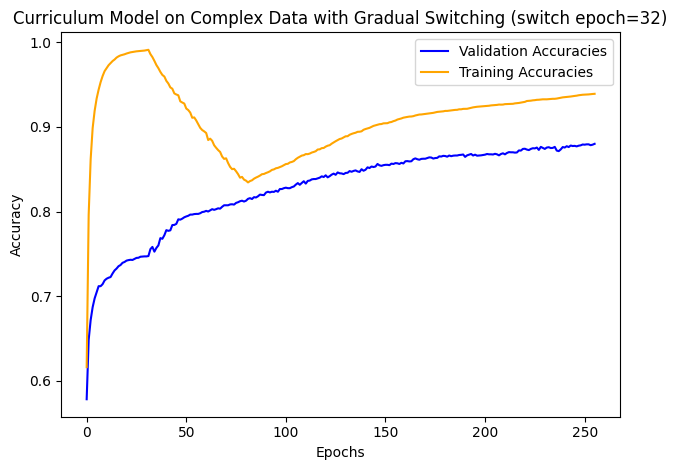

Validation accuracy of model at switch epoch 32: 0.88
Training curriculum model at switch epoch=64


Curriculum training on basic data complete. Now training curriculum model on complex data...


Gradual switching phase complete. Now training completely on switch loader data...


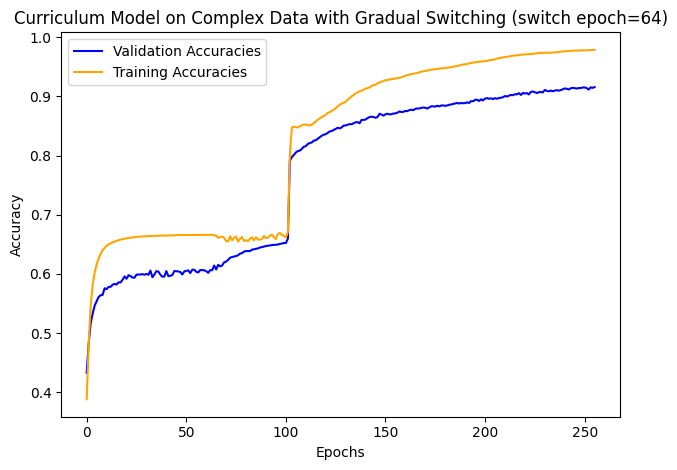

Validation accuracy of model at switch epoch 64: 0.9158
Training curriculum model at switch epoch=128


Curriculum training on basic data complete. Now training curriculum model on complex data...


Gradual switching phase complete. Now training completely on switch loader data...


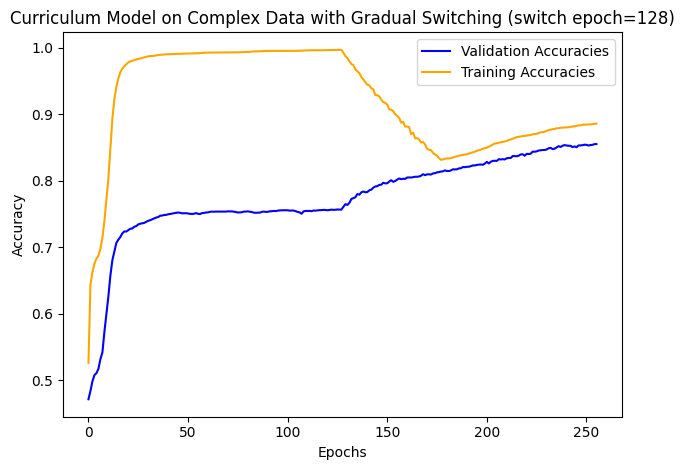

Validation accuracy of model at switch epoch 128: 0.8554


In [14]:
gs_complex_curriculum_accs = curriculum_experiment(input_size=input_size, hidden_size=hidden_size, learning_rate=learning_rate, val_loader=val_loader_combined,
                                                   loader_basic=train_loader_complex, loader_combined=train_loader_combined,
                                                   switch_loader_name='Combined', save_model=True, gradual_switch=True,
                                                   plot_title='Curriculum Model on Complex Data with Gradual Switching')

Training curriculum models with Combined Switch Loader...
Training curriculum model at switch epoch=0
Curriculum training on basic data complete. Now training curriculum model on complex data...


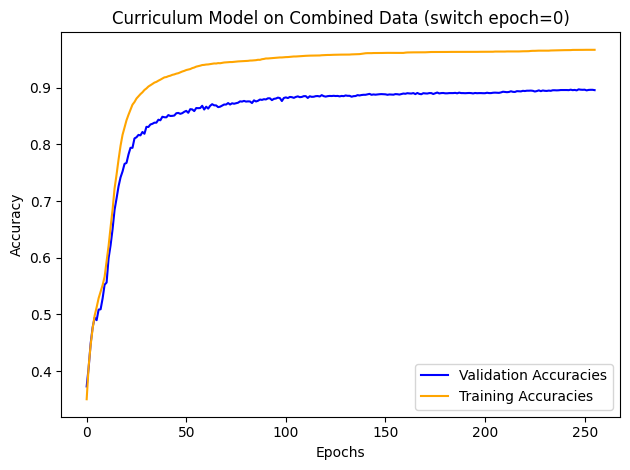

Validation accuracy of model at switch epoch 0: 0.8958
Training curriculum model at switch epoch=2


Curriculum training on basic data complete. Now training curriculum model on complex data...


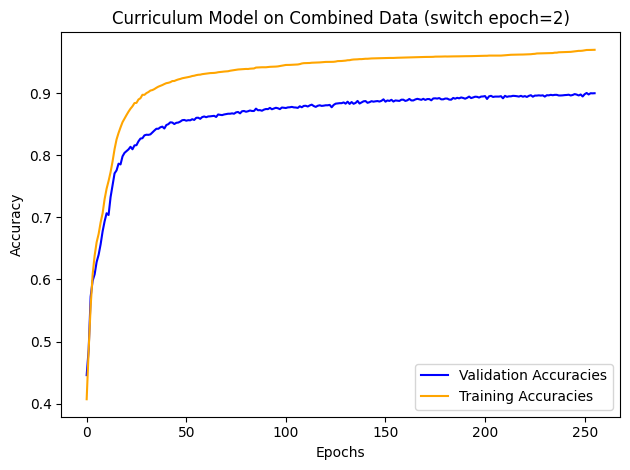

Validation accuracy of model at switch epoch 2: 0.8998
Training curriculum model at switch epoch=4


Curriculum training on basic data complete. Now training curriculum model on complex data...


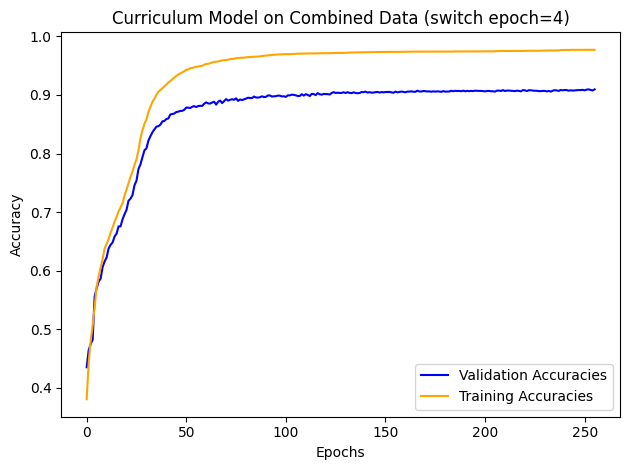

Validation accuracy of model at switch epoch 4: 0.9094
Training curriculum model at switch epoch=8


Curriculum training on basic data complete. Now training curriculum model on complex data...


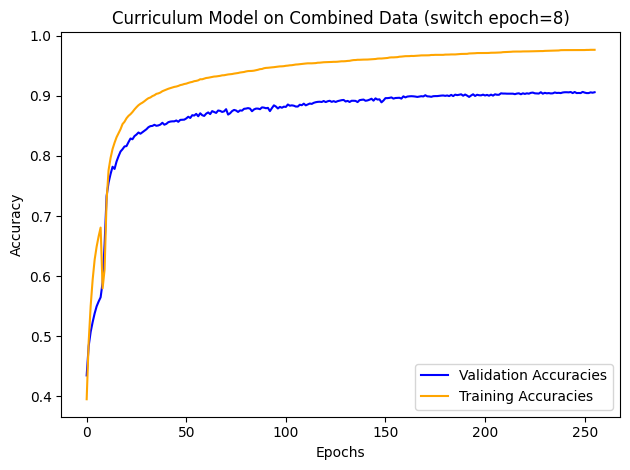

Validation accuracy of model at switch epoch 8: 0.906
Training curriculum model at switch epoch=16


Curriculum training on basic data complete. Now training curriculum model on complex data...


Model training has reached early stopping at epoch 234.


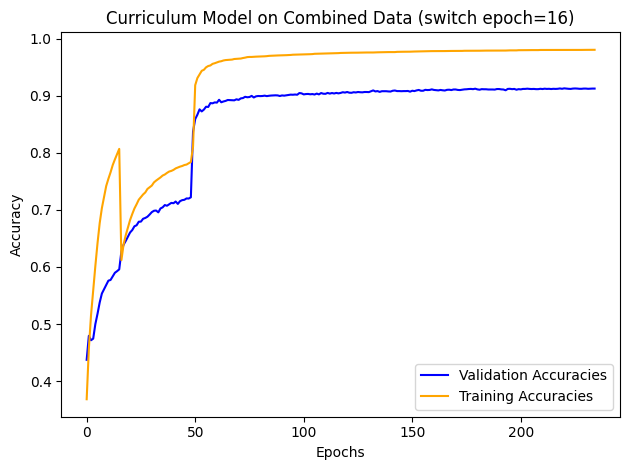

Validation accuracy of model at switch epoch 16: 0.9124
Training curriculum model at switch epoch=32


Curriculum training on basic data complete. Now training curriculum model on complex data...


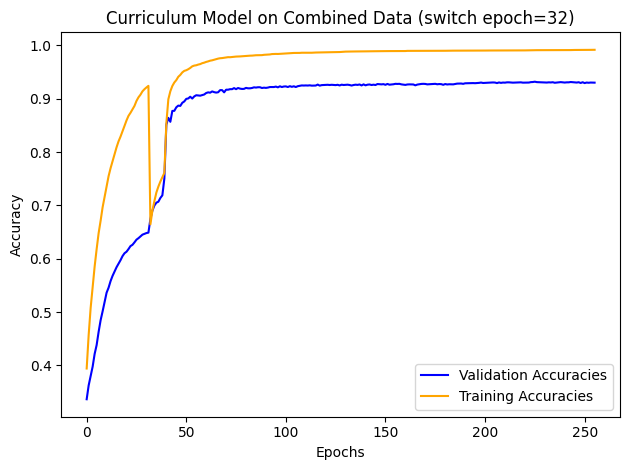

Validation accuracy of model at switch epoch 32: 0.9302
Training curriculum model at switch epoch=64


Curriculum training on basic data complete. Now training curriculum model on complex data...


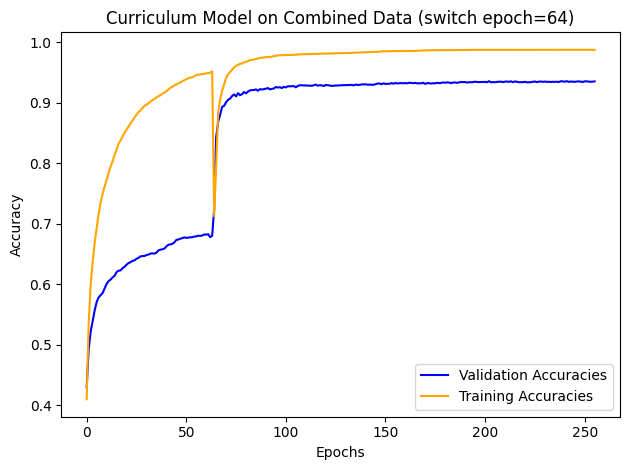

Validation accuracy of model at switch epoch 64: 0.9354
Training curriculum model at switch epoch=128


Curriculum training on basic data complete. Now training curriculum model on complex data...


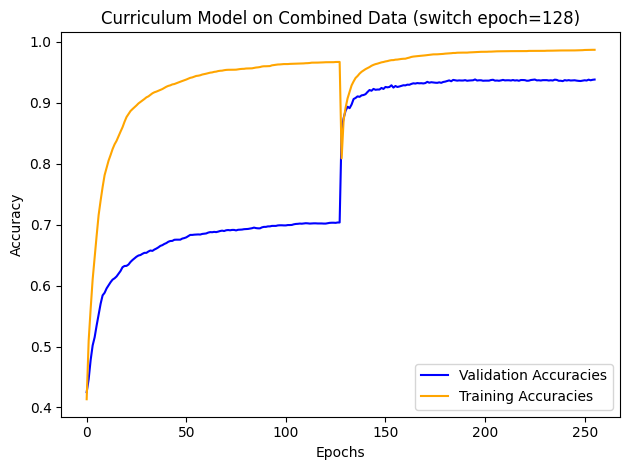

Validation accuracy of model at switch epoch 128: 0.9382


In [15]:
# discrete switch from easy to hard data
combined_curriculum_accs = curriculum_experiment(input_size=input_size, hidden_size=hidden_size, learning_rate=learning_rate, val_loader=val_loader_combined,
                                                 loader_basic=train_loader_basic, loader_combined=train_loader_combined,
                                                 switch_loader_name='Combined', save_model=True, gradual_switch=False,
                                                 plot_title='Curriculum Model on Combined Data')

Training curriculum models with Combined Switch Loader...
Training curriculum model at switch epoch=0
Curriculum training on basic data complete. Now training curriculum model on complex data...


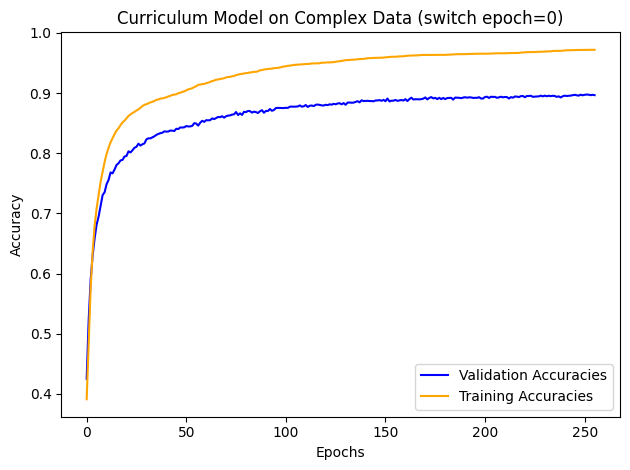

Validation accuracy of model at switch epoch 0: 0.8966
Training curriculum model at switch epoch=2


Curriculum training on basic data complete. Now training curriculum model on complex data...


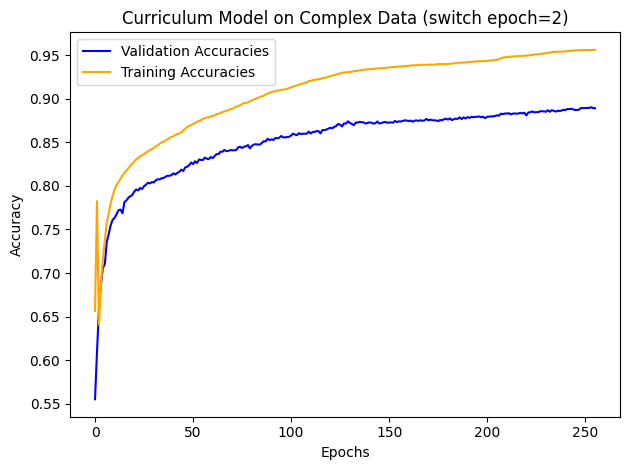

Validation accuracy of model at switch epoch 2: 0.889
Training curriculum model at switch epoch=4


Curriculum training on basic data complete. Now training curriculum model on complex data...


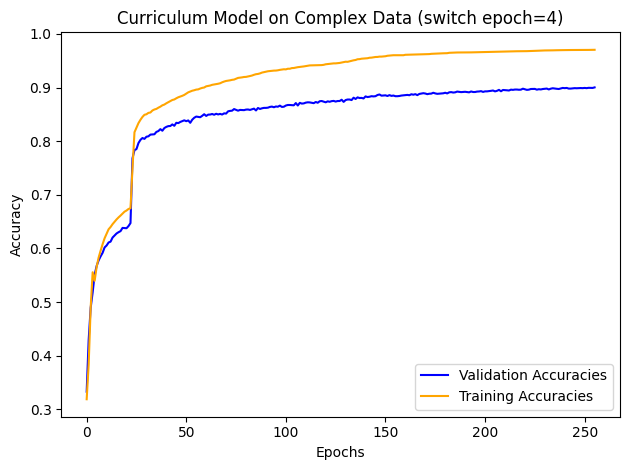

Validation accuracy of model at switch epoch 4: 0.9002
Training curriculum model at switch epoch=8


Curriculum training on basic data complete. Now training curriculum model on complex data...


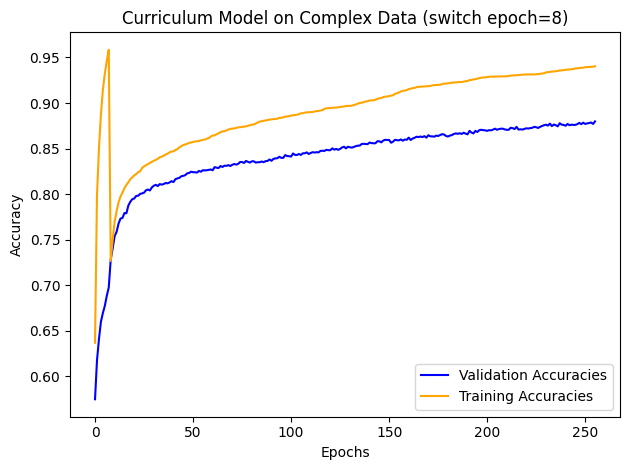

Validation accuracy of model at switch epoch 8: 0.8798
Training curriculum model at switch epoch=16


Curriculum training on basic data complete. Now training curriculum model on complex data...


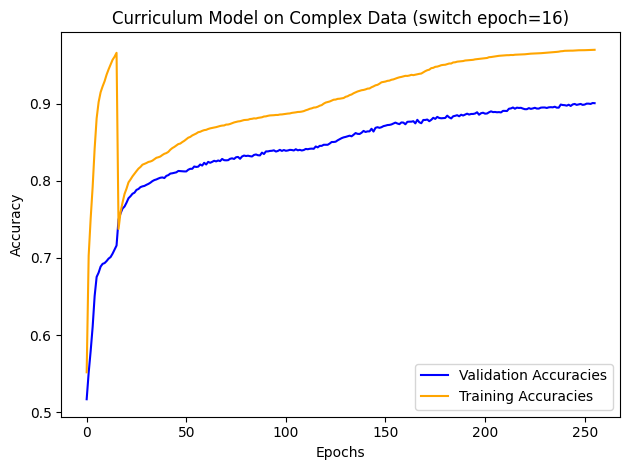

Validation accuracy of model at switch epoch 16: 0.901
Training curriculum model at switch epoch=32


Curriculum training on basic data complete. Now training curriculum model on complex data...


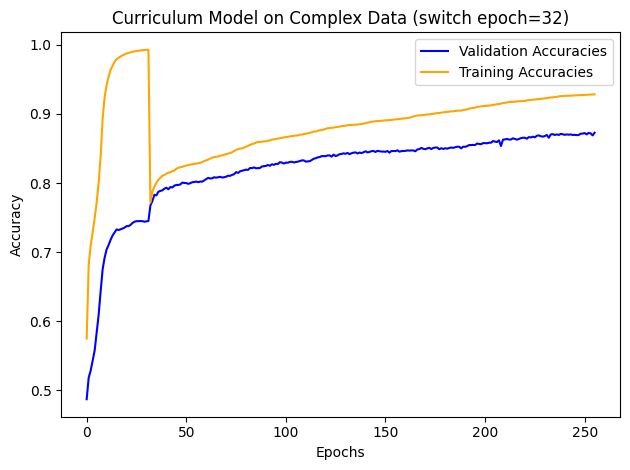

Validation accuracy of model at switch epoch 32: 0.8728
Training curriculum model at switch epoch=64


Curriculum training on basic data complete. Now training curriculum model on complex data...


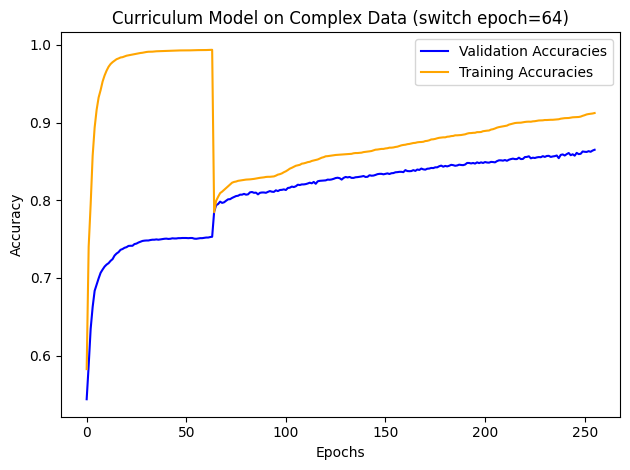

Validation accuracy of model at switch epoch 64: 0.865
Training curriculum model at switch epoch=128


Curriculum training on basic data complete. Now training curriculum model on complex data...


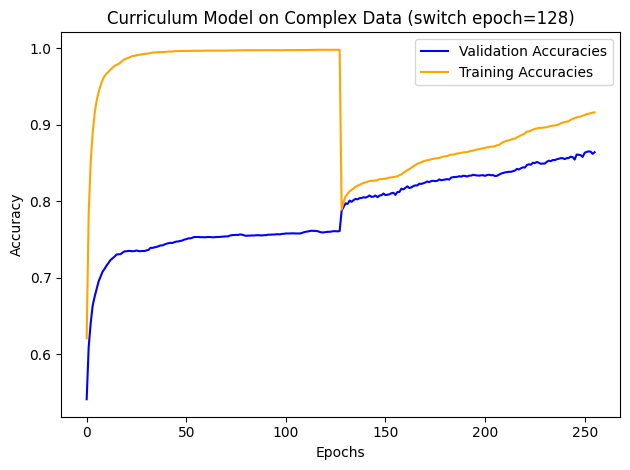

Validation accuracy of model at switch epoch 128: 0.8642
All curriculum models completed training!


In [16]:
complex_curriculum_accs = curriculum_experiment(input_size=input_size, hidden_size=hidden_size, learning_rate=learning_rate, val_loader=val_loader_combined,
                                                loader_basic=train_loader_complex, loader_combined=train_loader_combined,
                                                switch_loader_name='Combined', save_model=True, gradual_switch=False,
                                                plot_title='Curriculum Model on Complex Data')

print("All curriculum models completed training!")

In [62]:
import sys
if 'plot_curriculum_experiment' in sys.modules:
    print("deleting")
    del sys.modules['plot_curriculum_experiment']

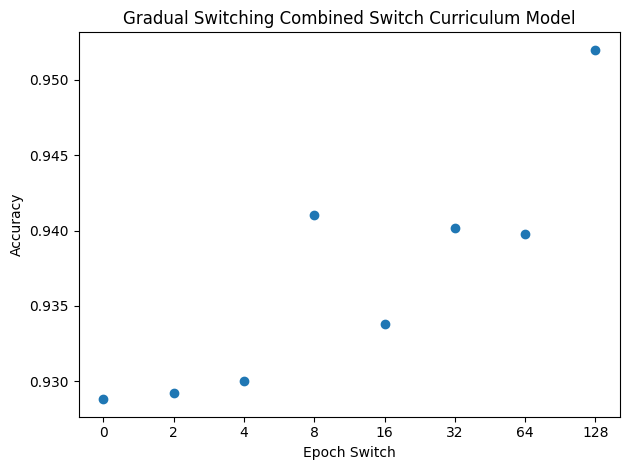

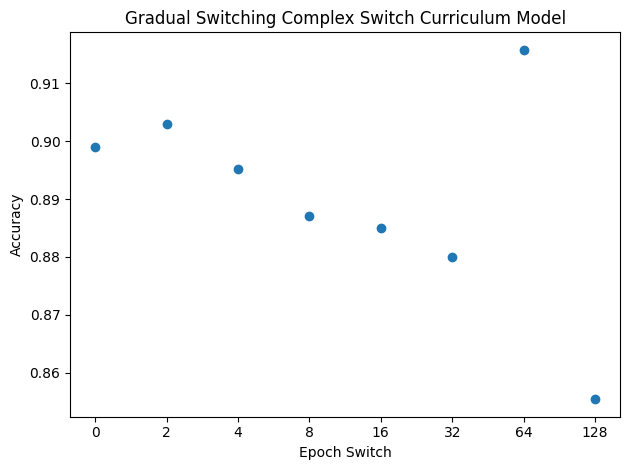

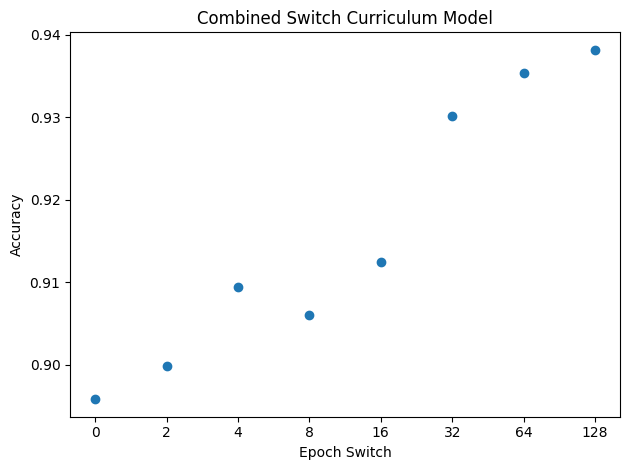

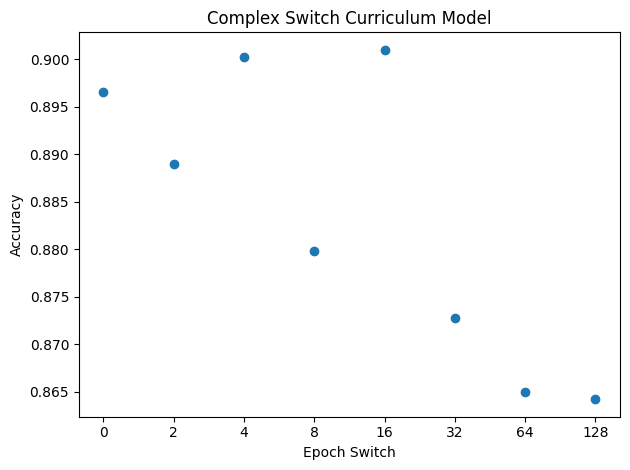

In [64]:
import importlib
import experiment

importlib.reload(experiment)

experiment.plot_curriculum_experiment(gs_combined_curriculum_accs,
                           title='Gradual Switching Combined Switch Curriculum Model')
experiment.plot_curriculum_experiment(gs_complex_curriculum_accs,
                           title='Gradual Switching Complex Switch Curriculum Model')
experiment.plot_curriculum_experiment(combined_curriculum_accs,
                           title='Combined Switch Curriculum Model')
experiment.plot_curriculum_experiment(complex_curriculum_accs,
                           title='Complex Switch Curriculum Model')

Training complex model on complex data...


Model training has reached early stopping at epoch 165.


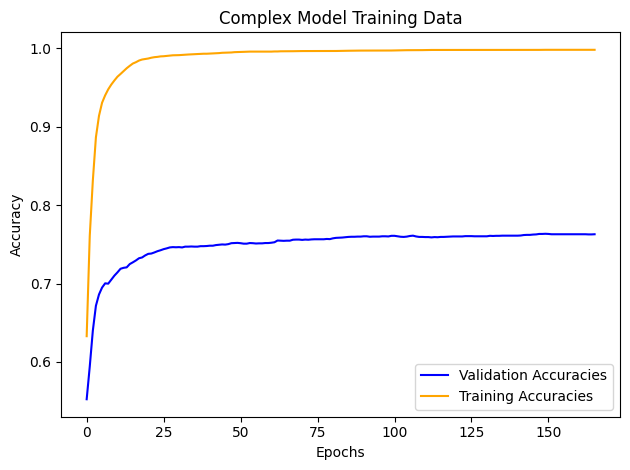

complex validation accuracy after training: 0.7628
Complex data training complete for complex model!


In [18]:
model_complex = FeedForward(input_size=input_size,
                            hidden_size=hidden_size, output_size=3)

optimizer_complex = optim.SGD(model_complex.parameters(), lr=learning_rate)

print("Training complex model on complex data...")

model_complex, _ = train_model(model=model_complex, loader=train_loader_complex,
                         loss_fn=ce_loss, optimizer=optimizer_complex, 
                         num_epochs=num_epochs, val_loader=val_loader_combined, 
                         verbose=True, model_type='complex', 
                         plot_title='Complex Model Training Data')

if save_model:
    torch.save(model_complex.state_dict(), 'models/model_complex.pth')

print("Complex data training complete for complex model!")

Training combined model on all data...


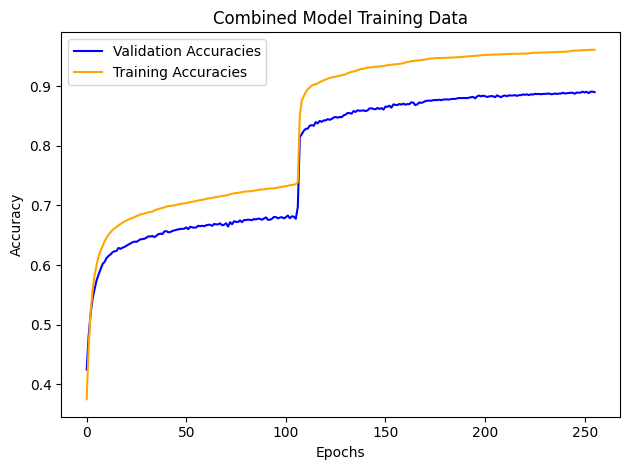

basic validation accuracy after training: 0.8902
Combined data training complete on combined model!


In [19]:
model_combined = FeedForward(input_size=input_size,
                             hidden_size=hidden_size, output_size=3)

optimizer_combined = optim.SGD(
    model_combined.parameters(), lr=learning_rate)

print("Training combined model on all data...")

model_combined, _ = train_model(model=model_combined, loader=train_loader_combined,
                             loss_fn=ce_loss, optimizer=optimizer_combined, num_epochs=num_epochs,
                             val_loader=val_loader_combined, verbose=True, plot_title='Combined Model Training Data')

if save_model:
    torch.save(model_combined.state_dict(), 'models/model_combined.pth')

print("Combined data training complete on combined model!")

In [66]:
from model import eval_model

model_basic = FeedForward(input_size=input_size, hidden_size=hidden_size, output_size=3)

model_combined_curriculum = FeedForward(input_size=input_size, hidden_size=hidden_size, output_size=3)
model_complex_curriculum = FeedForward(input_size=input_size, hidden_size=hidden_size, output_size=3)
model_gs_combined_curriculum = FeedForward(input_size=input_size, hidden_size=hidden_size, output_size=3)
model_gs_complex_curriculum = FeedForward(input_size=input_size, hidden_size=hidden_size, output_size=3)

model_complex = FeedForward(input_size=input_size, hidden_size=hidden_size, output_size=3)
model_combined = FeedForward(input_size=input_size, hidden_size=hidden_size, output_size=3)

model_basic.load_state_dict(torch.load('models/model_basic.pth'))

# choose curriculum models from switch epoch of highest validation accuracy
best_combined = combined_curriculum_accs.index(max(combined_curriculum_accs))
best_complex = complex_curriculum_accs.index(max(complex_curriculum_accs))
best_gs_combined = gs_combined_curriculum_accs.index(max(gs_combined_curriculum_accs))
best_gs_complex = gs_complex_curriculum_accs.index(max(gs_complex_curriculum_accs))

best_combined = 0 if best_combined == 0 else 2 ** best_combined
best_complex = 0 if best_complex == 0 else 2 ** best_complex
best_gs_combined = 0 if best_gs_combined == 0 else 2 ** best_gs_combined
best_gs_complex = 0 if best_gs_complex == 0 else 2 ** best_gs_complex

model_combined_curriculum.load_state_dict(torch.load(f'models/model_curriculum_{best_combined}.pth'))
model_complex_curriculum.load_state_dict(torch.load(f'models/model_curriculum_{best_complex}.pth'))
model_gs_combined_curriculum.load_state_dict(torch.load(f'models/model_curriculum_{best_gs_combined}.pth'))
model_gs_complex_curriculum.load_state_dict(torch.load(f'models/model_curriculum_{best_gs_complex}.pth'))

model_complex.load_state_dict(torch.load('models/model_complex.pth'))
model_combined.load_state_dict(torch.load('models/model_combined.pth'))

# model performance on combined data
basic_test_acc = eval_model(model=model_basic, loader=test_loader_combined, model_type='basic', verbose=True)
curriculum_combined_test_acc = eval_model(model=model_combined_curriculum, loader=test_loader_combined, model_type='combined curriculum (no gs)', verbose=True)
curriculum_complex_test_acc = eval_model(model=model_complex_curriculum, loader=test_loader_combined, model_type='complex curriculum (no gs)', verbose=True)
curriculum_gs_combined_test_acc = eval_model(model=model_gs_combined_curriculum, loader=test_loader_combined, model_type='combined curriculum (with gs)', verbose=True)
curriculum_gs_complex_test_acc = eval_model(model=model_gs_complex_curriculum, loader=test_loader_combined, model_type='complex curriculum (with gs)', verbose=True)
complex_test_acc = eval_model(model=model_complex, loader=test_loader_combined, model_type='complex', verbose=True)
combined_test_acc = eval_model(model=model_combined, loader=test_loader_combined, model_type='combined', verbose=True)

basic test accuracy: 0.689
combined curriculum (no gs) test accuracy: 0.641
complex curriculum (no gs) test accuracy: 0.633
combined curriculum (with gs) test accuracy: 0.641
complex curriculum (with gs) test accuracy: 0.6322
complex test accuracy: 0.763
combined test accuracy: 0.8976
